In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F

In [2]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    )

In [3]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    )

In [4]:
save_dir_path = "./save_directory_5" 


In [5]:
with open("all_dataframes.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
train_df = loaded_dfs['train_df']
val_df = loaded_dfs['val_df']
test_df = loaded_dfs['test_df']

train_id_df = loaded_dfs['train_id_df']
val_id_df = loaded_dfs['val_id_df']
test_id_df = loaded_dfs['test_id_df']
test_df_high_energy = loaded_dfs['test_df_high_energy']

val_df_high_energy = loaded_dfs['val_df_high_energy']
val_id_df_high_energy = loaded_dfs['val_id_df_high_energy']
test_id_df_high_energy = loaded_dfs['test_id_df_high_energy']

In [6]:
train_id_df_added = add_phi_A_columns(train_id_df)
val_id_df_added = add_phi_A_columns(val_id_df)
val_id_df_high_energy_added = add_phi_A_columns(val_id_df_high_energy)


📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 661 with the value: 37.739334, the losses of the last 5 epochs are: [38.91818809509277, 38.824930826822914, 38.579562187194824, 38.4901639620463, 38.377561251322426]
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 691 with the value: 70.870759, the losses of the last 5 epochs are: [71.22750264406204, 71.26035994291306, 71.14741080999374, 71.09236737092336, 71.17749178409576]
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 674 with the value: 42.190150, the losses of the last 5 epochs are: [42.479582687218986, 42.40627756714821, 42.487240105867386, 42.50103512406349, 42.47566188375155]
  Lowest loss of metric 'val_variance_loss_' recorded in epoch 696 with the value: 66.398179, the losses of the last 5 epochs are: [67.3774463335673, 67.28098678588867, 66.98439470926921, 66.78218619028728, 66.66173553466797]
  Lowest loss of metric 'train_total_los

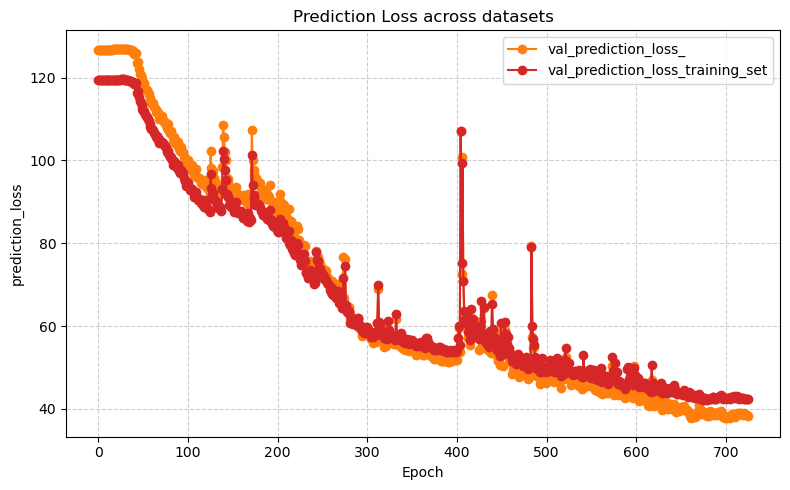

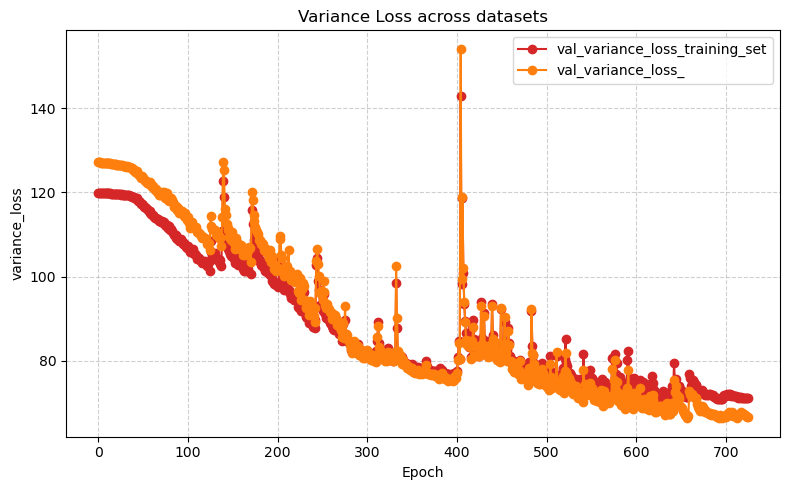

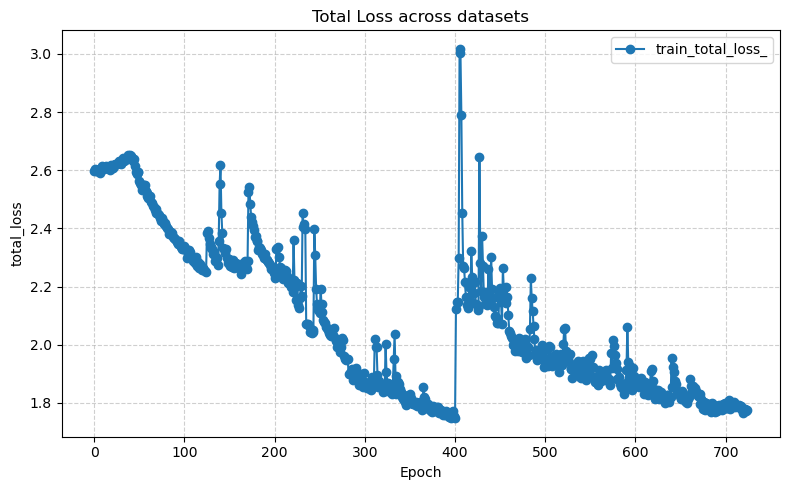

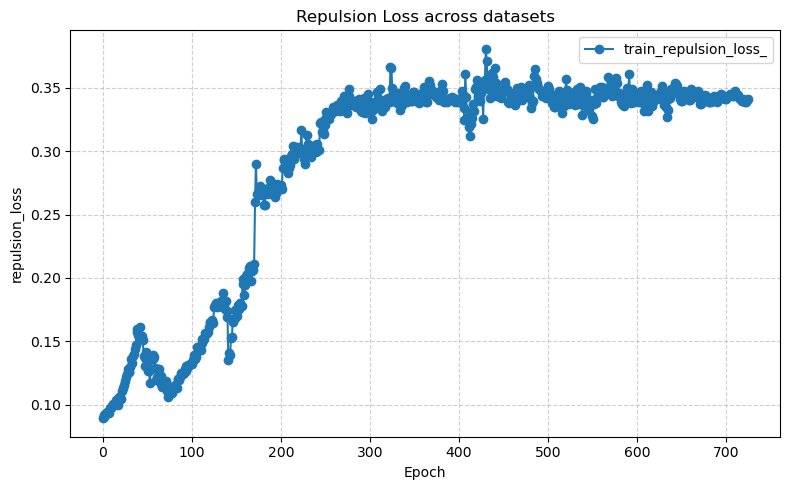

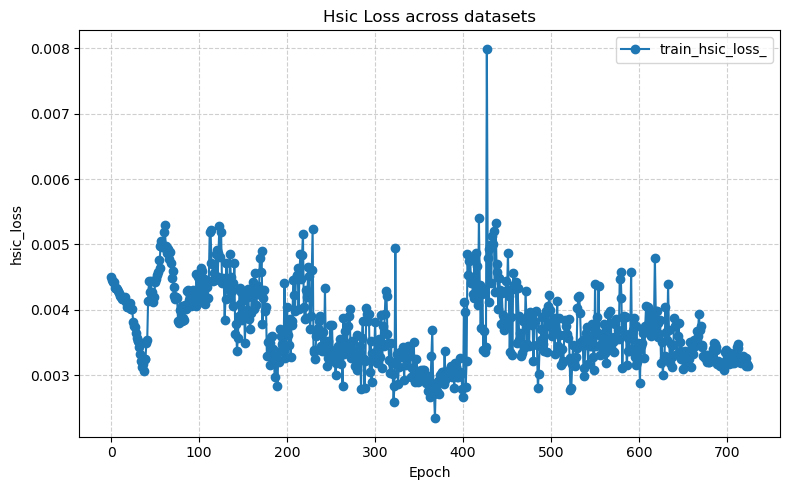

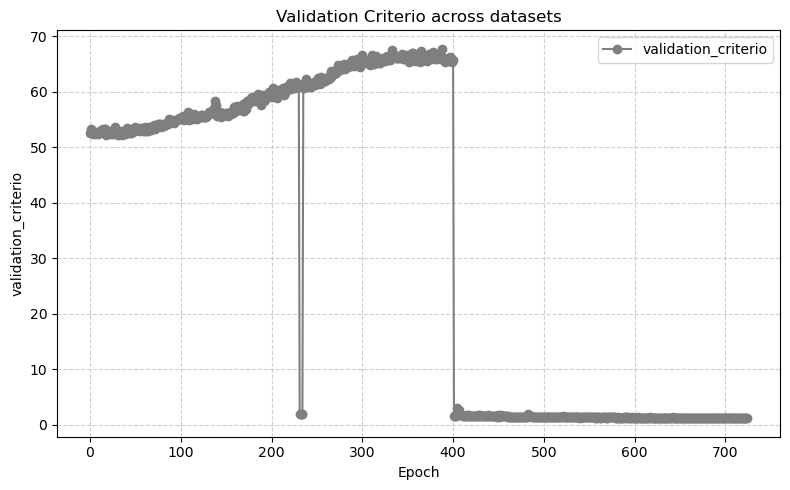


✅ Visualization complete.


In [7]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "val_variance_loss_training_set", "val_prediction_loss_training_set", "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "train_hsic_loss_" , "validation_criterio"],
plot_on_same_graph=True,
verbose=True
)



📊 Processing directory: val_trajectories_data

For the epoch_369 in val_trajectories_data the values are:
92: X_mean = 12.6105 ± 7.1046, U_mean = -5.6311 ± 7.6400 and A=13.564677634903196, phi=-2.7802771843251053
64: X_mean = 11.9971 ± 5.4279, U_mean = -5.0146 ± 5.2548 and A=11.313750136394223, phi=-2.8600808883112765
6: X_mean = 14.4939 ± 3.1418, U_mean = 3.7136 ± 3.4089 and A=3.4643759649388923, phi=0.5272390069263062

📊 Processing directory: val_train_set_trajectories_data

For the epoch_369 in val_train_set_trajectories_data the values are:
2: X_mean = 9.2911 ± 3.8257, U_mean = 0.1246 ± 3.4660 and A=2.0004916751010886, phi=-1.322539930867642
120: X_mean = 9.9064 ± 7.5893, U_mean = 11.0826 ± 9.3407 and A=15.491933918298438, phi=-0.3577443145058989
96: X_mean = 12.0686 ± 6.5442, U_mean = 9.9314 ± 7.8442 and A=13.856421371448707, phi=0.050548714589954684

📊 Processing directory: val_high_energy_trajectories_data

For the epoch_369 in val_high_energy_trajectories_data the values are:


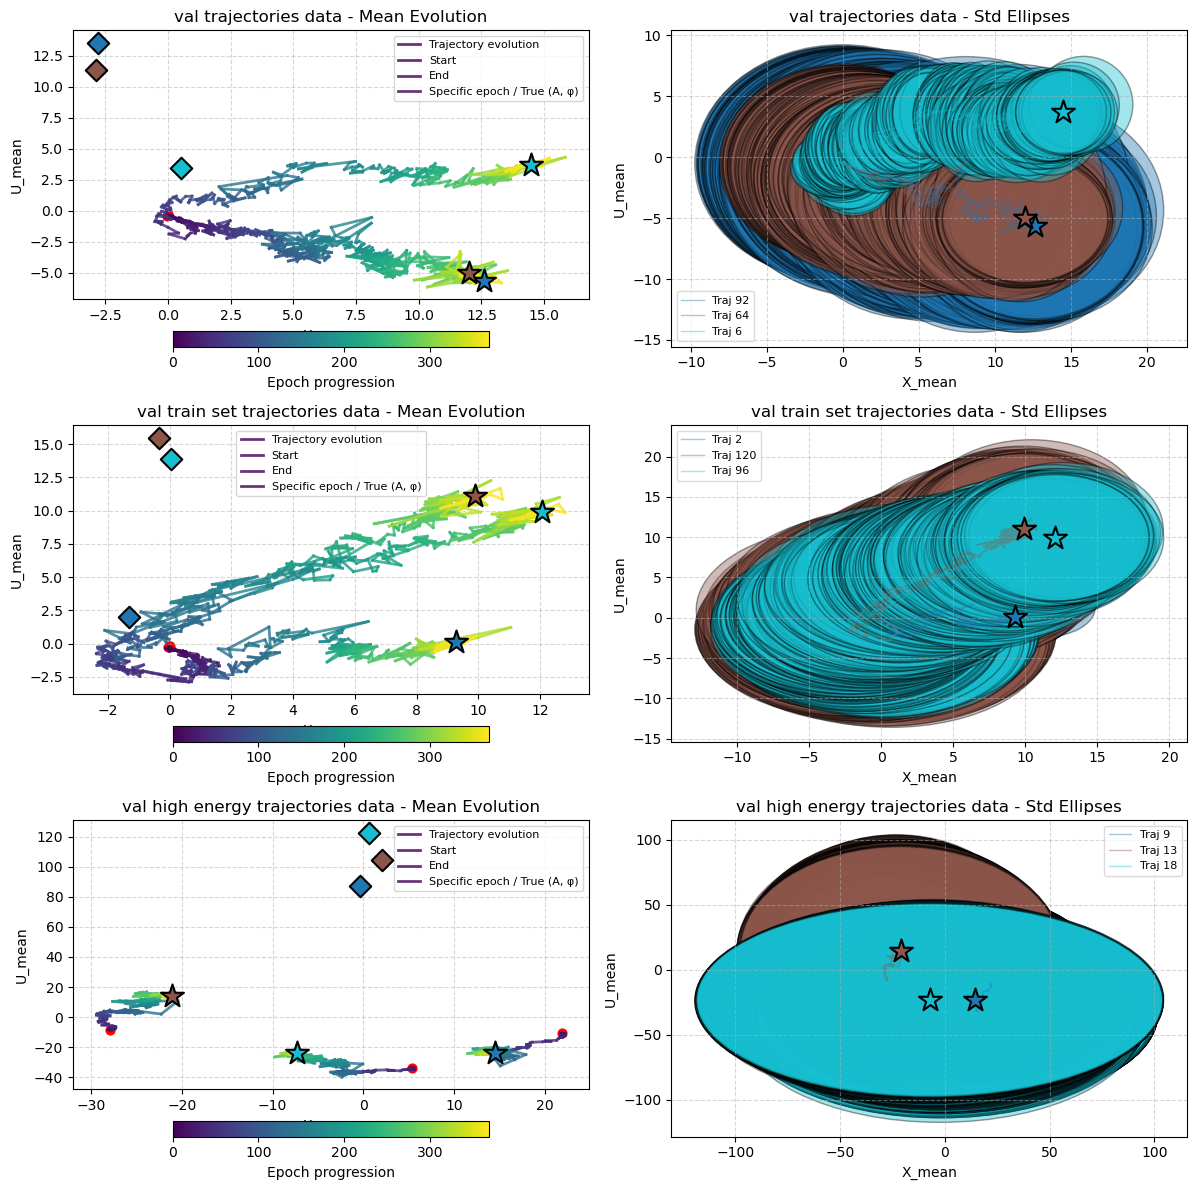


✅ Mean + Std (ellipse) visualization complete.


In [13]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_added,val_id_df_added=val_id_df_added,val_id_df_high_energy_added=val_id_df_high_energy_added)

In [152]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch="last",
    train_id_df_added=train_id_df_added,
    val_id_df_added=val_id_df_added,
    val_id_df_high_energy_added=val_id_df_high_energy_added
)

📂 Using data from epoch: epoch_601
✅ Data extraction complete.


In [153]:
np.cov(val_train_differencies_set_df['A'], val_train_differencies_set_df['phi'])

array([[14.40715418,  0.41387528],
       [ 0.41387528,  3.84213375]])

In [154]:
np.cov(val_train_differencies_set_df['X_mean'], val_train_differencies_set_df['U_mean'])

array([[ 9.32446665, -2.50051144],
       [-2.50051144, 35.13844367]])

14.94

In [155]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['A']),
    y=torch.Tensor(val_train_differencies_set_df['phi']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

In [156]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.0022)

0.0657

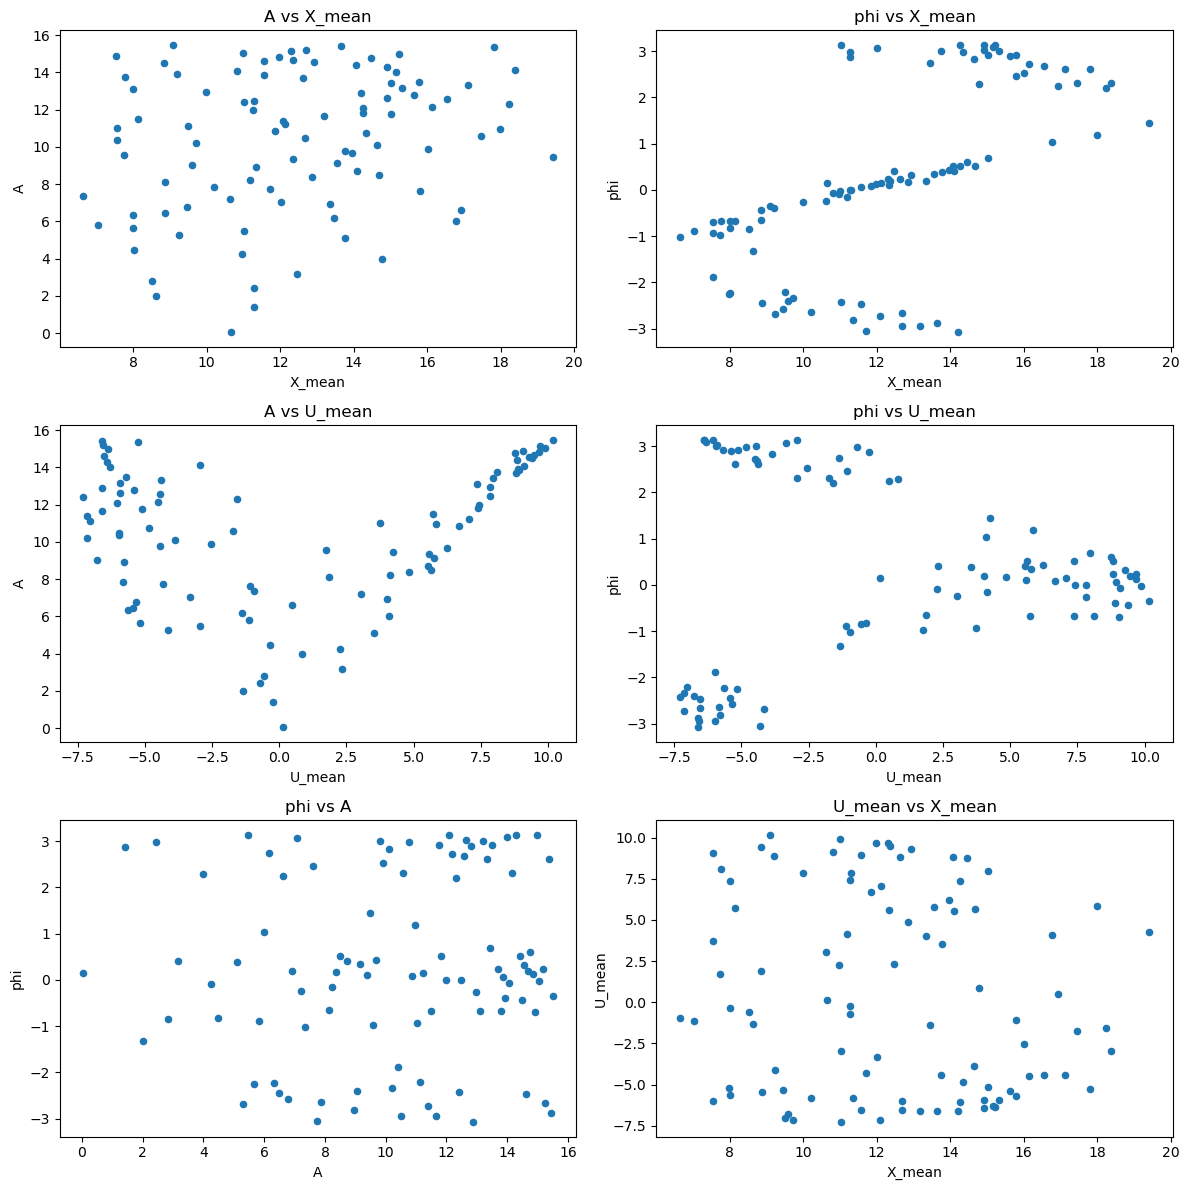

In [157]:
plot_differencies(val_train_differencies_set_df)

In [120]:
analyze_folders_means(save_dir_path, locate_epoch=None)

📊 Analyzing 500 epochs across 3 directories...

📁 Processing directory: val_trajectories_data


/tmp/ipykernel_3986/952525528.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")



📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


KeyboardInterrupt: 

In [198]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [10, 20, 10],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
        
        # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,
    bound_innit=0.0,
).to(device)

checkpoint_path = os.path.join(save_dir_path, "checkpoint_epoch_700.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:3531: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  repulsion_loss_class=repulsion_loss_class,


In [199]:
count_parameters(mapping_net)

9500

In [200]:
test_id_df

,trajectory_id,x0,u0,energy,generated_points,start_index,end_index
53,53,1.949238,10.109480,53.000562,242,12826,13068
81,81,6.964184,-10.653676,81.000331,242,19602,19844
39,39,-4.811351,7.406231,39.000678,242,9438,9680
117,117,-4.987248,14.461239,117.000033,242,28314,28556
75,75,-6.527532,-10.363015,75.000380,242,18150,18392
12,12,3.302146,-3.619065,12.000901,242,2904,3146
88,88,0.494051,13.257317,88.000273,242,21296,21538
7,7,-0.169535,3.738067,7.000942,242,1694,1936
67,67,10.305415,-5.272506,67.000446,242,16214,16456
101,101,-6.898615,12.426160,101.000165,242,24442,24684


Observed time points: [0.]


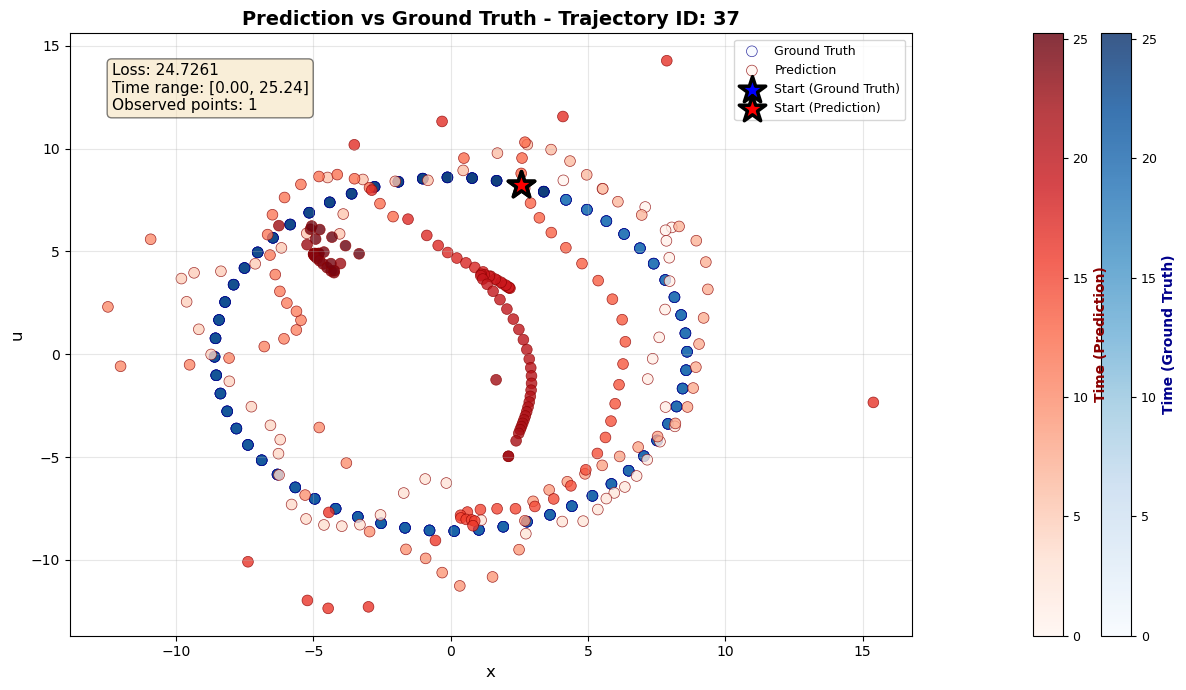

In [202]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss, test_id_df=test_id_df, test_df=test_df, trajectory_id=37, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0], connect_points=False)

In [171]:
val_id_df_high_energy_added

,trajectory_id,x0,u0,energy,phi,A,generated_points,start_index,end_index
4,4,-21.000642,-55.608510,1766.666667,-2.780499,59.441848,46,184,230
18,18,71.984881,99.389018,7530.000000,0.626832,122.719192,46,828,874
11,11,6.253068,96.216245,4648.333333,0.064898,96.419224,46,506,552
9,9,-28.967503,82.528079,3825.000000,-0.337567,87.464278,46,414,460
17,17,-39.613535,112.549698,7118.333333,-0.338424,119.317504,46,782,828
19,19,84.016100,-93.939493,7941.666667,2.411900,126.029097,46,874,920
5,5,-1.268729,-65.992856,2178.333333,-3.122370,66.005050,46,230,276
21,21,2.603316,132.375310,8765.000000,0.019664,132.400906,46,966,1012
13,13,91.704182,-50.335636,5471.666667,2.072788,104.610388,46,598,644
1,1,-22.047887,24.025487,531.666667,-0.742502,32.608792,46,46,92


In [77]:
step_1_mlp_params = {}
step_1_c1_values = []
step_1_c2_values = []
step_1_gamma_values = []
step_1_a_values = []

step_2_mlp_params = {}
step_2_c1_values = []
step_2_c2_values = []
step_2_gamma_values = []
step_2_a_values = []

for name, param in mapping_net.named_parameters():
    if ('step_1' in name):
        if ('G_network' in name):
            step_1_mlp_params[name] = param
        elif ('c1' in name): #c1
            step_1_c1_values.append(param.item())
        elif ('c2' in name): #c2
            step_1_c2_values.append(param.item())
        elif ('gamma' in name): #gamma
            step_1_gamma_values.append(param.item())

    if ('step_2' in name):
        if ('G_network' in name):
            step_2_mlp_params[name] = param
        elif ('c1' in name): #c1
            step_2_c1_values.append(param.item())
        elif ('c2' in name): #c2
            step_2_c2_values.append(param.item())
        elif ('gamma' in name): #gamma
            step_2_gamma_values.append(param.item())

for layer in mapping_net.layers:
    step_1_a_values.append(layer.step_1.a.item())
    step_2_a_values.append(layer.step_2.a.item())

In [159]:
step_1_a_values

[1.2626569271087646,
 1.2673213481903076,
 1.2659708261489868,
 1.2578362226486206,
 1.2599694728851318,
 1.2930964231491089,
 1.2622381448745728,
 1.2708702087402344,
 1.3132054805755615,
 1.343143343925476]

In [160]:
step_2_a_values

[1.248018741607666,
 1.250362515449524,
 1.2570489645004272,
 1.2505970001220703,
 1.2561368942260742,
 1.2495460510253906,
 1.2497903108596802,
 1.2500642538070679,
 1.2609286308288574,
 1.27146315574646]

In [75]:
mapping_net_test = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
        n_layers=10,
        # MLP Architecture parameters
        hidden_dims= [10, 20, 10],
        n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
        activation = 'gelu',
        activation_params = None,
        final_activation = None,   #Final layer activation function
        tanh_wrapper = False,
        
        # Initialization parameters
        weight_init = 'orthogonal',
        weight_init_params = {'gain': 1},
        bias_init = 'zeros',
        bias_init_value = 0.0,
        
        
        # Architectural choices
        use_bias = True,
        
        # Input/Output parameters
        input_dim = 2,  # x or u and t
        output_dim = 1,  # scalar G or F
        a_eps_min= 0.5,  # Minimum value for a
        a_eps_max= 2,  # Maximum value for a  
        a_k= 0.1,
        bound_innit=0.0,
    )

In [150]:
count_parameters(mapping_net_test)

9500

In [67]:
count_parameters(mapping_net_test)

15260